In [ ]:
!pip install pytorch-lightning
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.8 MB/s eta 0:00:00


In [ ]:
!pip install -U 'torch_xla>=1.13'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.11.1
    Uninstalling google-api-core-2.11.1:
      Successfully uninstalled google-api-core-2.11.1
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.84.0
    Uninstalling google-api-python-client-2.84.0:
      Successfully uninstalled google-api-python-client-2.84.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency co

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import os
from PIL import Image
from PIL.Image import Resampling

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook, tqdm
from time import sleep

from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mOEP6woH_9Ox8_Va0V5DibWttYR6u930' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1mOEP6woH_9Ox8_Va0V5DibWttYR6u930" -O train_dataset.zip && rm -rf /tmp/cookies.txt

# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1mOEP6woH_9Ox8_Va0V5DibWttYR6u930'

!unzip train_dataset.zip

--2023-11-03 13:32:09--  https://docs.google.com/uc?export=download&confirm=t&id=1mOEP6woH_9Ox8_Va0V5DibWttYR6u930
Resolving docs.google.com (docs.google.com)... 74.125.197.102, 74.125.197.113, 74.125.197.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.197.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-a8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/omukc74e2m418g2vmhnu9u0ng3gkdhc0/1699018275000/12656769980704004828/*/1mOEP6woH_9Ox8_Va0V5DibWttYR6u930?e=download&uuid=e0980e5e-da94-4dfa-9dcf-2688353f9fab [following]
--2023-11-03 13:32:09--  https://doc-0g-a8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/omukc74e2m418g2vmhnu9u0ng3gkdhc0/1699018275000/12656769980704004828/*/1mOEP6woH_9Ox8_Va0V5DibWttYR6u930?e=download&uuid=e0980e5e-da94-4dfa-9dcf-2688353f9fab
Resolving doc-0g-a8-docs.googleusercontent.com (doc-0g-a8-docs.googleusercontent.com)... 142.250.107.132,

In [ ]:
class UpscalerDataset(Dataset):
    def __init__(self, path):
        self.filenames = []
        self.root = path
        for (_, _, files) in os.walk(path):
            for file in files:
                # TODO: Добавить аугментаций
                self.filenames.append(file)
            break

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(self.root + filename)

        image_width = image.size[0]
        image_height = image.size[1]
        image_preprocess = lambda lenght: lenght if lenght % 2 == 0 else lenght - 1

        image_preprocessed = image.crop((0, 0, image_preprocess(image_width), image_preprocess(image_height)))

        image_rescaled = image_preprocessed.copy()
        image_rescaled.thumbnail((image_rescaled.size[0] // 2, image_rescaled.size[1] // 2),
                                 resample=Resampling.BICUBIC)

        X = torch.tensor(np.array(image_rescaled, dtype=np.float32)).transpose(1, 2).transpose(0, 1)
        Y = torch.tensor(np.array(image_preprocessed, dtype=np.float32)).transpose(1, 2).transpose(0, 1)

        return X, Y

In [ ]:
batch_size = 8

In [ ]:
train_dataset = UpscalerDataset("./train/train/images/")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
valid_dataset = UpscalerDataset("./train/valid/images/")
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
test_dataset = UpscalerDataset("./test/images/")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class Upscaler(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.BatchNorm2d(3)
        self.l2 = nn.Conv2d(3, 24, (3, 3), padding=1)
        self.l3 = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.l4 = nn.Sigmoid()
        self.l5 = nn.BatchNorm2d(24)
        self.l6 = nn.Upsample(scale_factor=2)
        self.l7 = nn.Conv2d(24, 3, (3, 3), padding=1)
        self.l8 = nn.Sigmoid()
        self.l9 = nn.BatchNorm2d(3)
        self.l10 = nn.Upsample(scale_factor=2)
        self.l11 = nn.Sigmoid()

    def forward(self, x):
        y = self.l1(x)
        y = self.l2(y)
        y = self.l3(y)
        y = self.l4(y)
        y = self.l5(y)
        y = self.l6(y)
        y = self.l7(y)
        y = self.l8(y)
        y = self.l9(y)
        y = self.l10(y)

        return self.l11(y)

In [ ]:
class UpscalerModule(pl.LightningModule):
    def __init__(self, model, loss, lr=0.005):
        super().__init__()
        self.model = model
        self.lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze')
        self.loss = loss
        self.lr = lr

    def forward(self, x):
        logits = self.model(x)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_ = self.model(x)

        loss_value = self.loss(y / 255, y_)
        metric_value = self.lpips(y_, y / 255)

        self.log("train_loss", loss_value, on_epoch=True)
        self.log("train_metric", metric_value, on_epoch=True)

        return loss_value

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_ = model(x)

        metric_value = self.lpips(y / 255, y_)
        self.log("valid_metric", metric_value, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
model = UpscalerModule(Upscaler(), nn.MSELoss())

# TODO: valid_dataloader -> trainer.fit(...)
trainer = pl.Trainer()
trainer.fit(model=model, train_dataloaders=train_loader)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 23.2MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callback

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
output = model(test_dataset[3][0][None, :])

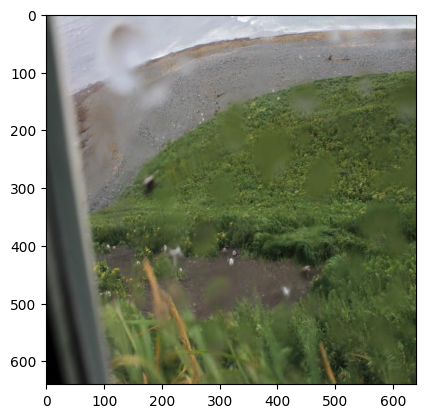

In [ ]:
real_image = Image.fromarray(np.uint8(test_dataset[3][1].transpose(0, 1).transpose(1, 2)))
plt.imshow(real_image)

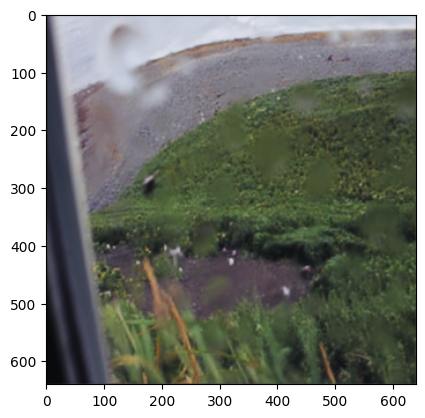

In [ ]:
model_image = Image.fromarray(np.uint8(output.cpu().detach().transpose(1, 2).transpose(2, 3)[0] * 255))
plt.imshow(model_image)